In [42]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

csv_path = ".\Stock-Market-Data\\back_data.csv"

df = pd.read_csv(csv_path)

# Use company symbol to find all occurences
df.set_index('symbol', inplace=True)
stock_a = df#.loc['A']
TRAINING = int(len(stock_a) * .8)

# Filter unwanted features
features_list = ['open', 'high', 'low', 'close']
features = stock_a[features_list]

features.index = stock_a['date']
features.head()

,open,high,low,close
date,,,,
2003-10-01,22.15,22.52,22.04,22.25
2003-10-02,22.10,22.18,21.84,21.99
2003-10-03,23.10,23.47,22.22,23.00
2003-10-06,23.00,23.23,22.81,23.03
2003-10-07,22.90,23.56,22.70,23.43


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001951E63C700>,
      dtype=object)

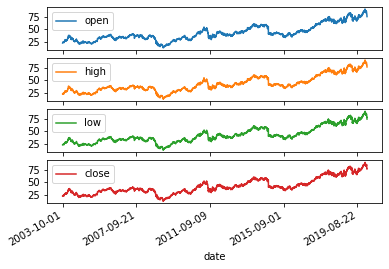

In [43]:
features.plot(subplots=True)

In [44]:
# Standardize the data
data = features.values
mean = data[:TRAINING].mean(axis=0)
std = data[:TRAINING].std(axis=0)
data = (data - mean) / std

In [45]:
STEP = 2
PRED = 7
x_train, y_train = multivariate_data(data, data[:, 1], 0,
                                     TRAINING, 90, PRED, STEP)
x_val, y_val = multivariate_data(data, data[:, 1],
                                 TRAINING, None, 
                                 90, PRED, STEP)                       

In [47]:
# Shuffle, Batch, and cache training data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(10000).batch(256).repeat()

# Repeat for value data
valid_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
valid_data = valid_data.cache().batch(256).repeat()

In [49]:
model = tf.keras.models.Sequential()
'''model.add(tf.keras.layers.LSTM(100, kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(20,activation='relu'))
model.add(tf.keras.layers.Dense(30,activation='sigmoid'))
optimizer = tf.keras.optimizers.RMSprop()
model.compile(loss='mean_squared_error', optimizer=optimizer)'''

'''model.add(tf.keras.layers.LSTM(units=50,return_sequences=True,input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(30))
model.compile(optimizer='adam',loss='mean_squared_error')'''

model.add(tf.keras.layers.LSTM(32,
                               return_sequences=True,
                               input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(16, activation='relu'))
model.add(tf.keras.layers.Dense(50))
model.add(tf.keras.layers.Dense(PRED))
model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = model.fit(train_data, epochs=10,
                                          steps_per_epoch=200,
                                          validation_data=valid_data,
                                          validation_steps=100)

Epoch 1/10
200/200 [==============================] - 18s 90ms/step - loss: 0.2138 - val_loss: 0.9810
Epoch 2/10
200/200 [==============================] - 17s 85ms/step - loss: 0.1318 - val_loss: 1.0121
Epoch 3/10
200/200 [==============================] - 17s 85ms/step - loss: 0.1211 - val_loss: 1.0944
Epoch 4/10
200/200 [==============================] - 17s 85ms/step - loss: 0.1153 - val_loss: 1.1532
Epoch 5/10
200/200 [==============================] - 18s 89ms/step - loss: 0.1117 - val_loss: 1.1265
Epoch 6/10
200/200 [==============================] - 20s 98ms/step - loss: 0.1098 - val_loss: 1.0553
Epoch 7/10
200/200 [==============================] - 21s 105ms/step - loss: 0.1079 - val_loss: 1.1788
Epoch 8/10
200/200 [==============================] - 21s 107ms/step - loss: 0.1068 - val_loss: 1.3057
Epoch 9/10
200/200 [==============================] - 22s 111ms/step - loss: 0.1051 - val_loss: 1.2983
Epoch 10/10
200/200 [==============================] - 19s 94ms/step - loss: 0.

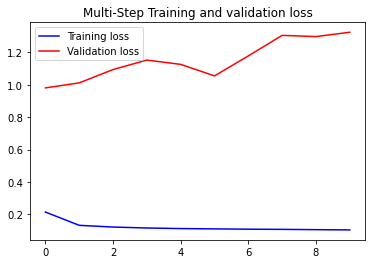

<RepeatDataset shapes: ((None, 45, 4), (None, 7)), types: (tf.float64, tf.float64)>

In [50]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')
valid_data

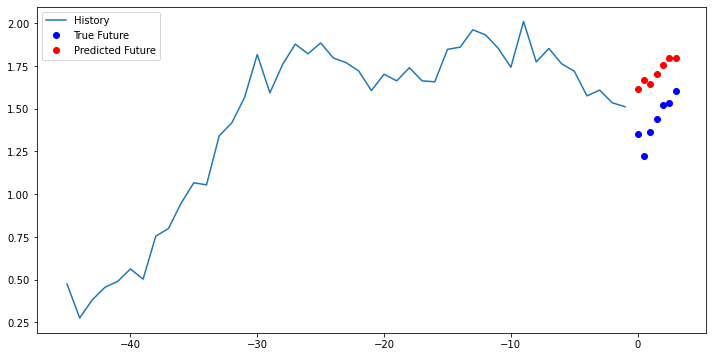

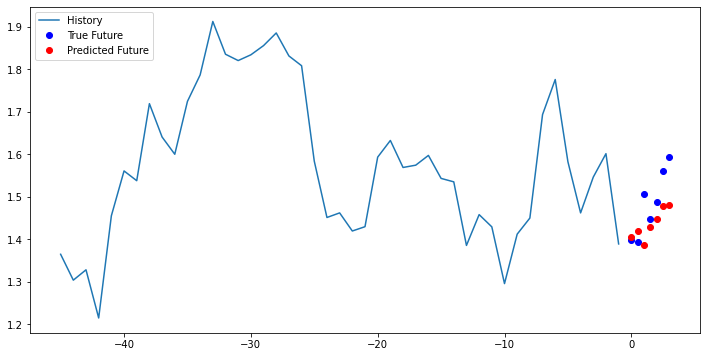

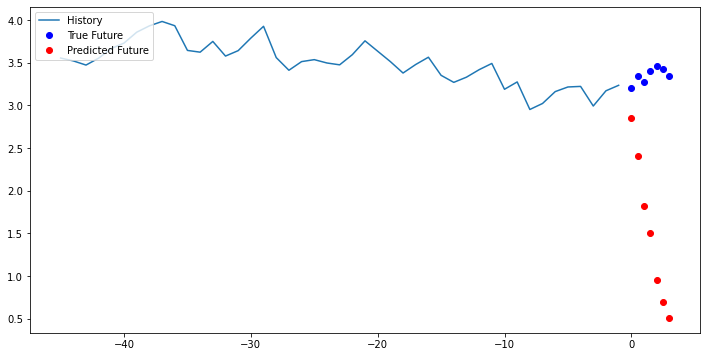

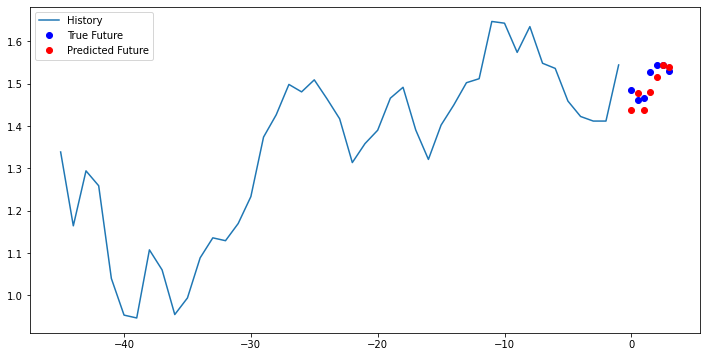

In [39]:
for x, y in valid_data.take(4):
  multi_step_plot(x[0], y[0], model.predict(x)[0])

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Create window based on data, step size, and given indices
    """
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
      end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
      indices = range(i-history_size, i, step)
      data.append(dataset[indices])

      if single_step:
        labels.append(target[i+target_size])
      else:
        labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [8]:
def plot_history(history, title):
    """
        Plot given history
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [7]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = list(range(-plot_data[0].shape[0], 0 ))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [20]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out) / STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out) / STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [5]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [4]:
def create_time_steps(length):
  return list(range(-length, 0))